## Check the relationship between learning order values and score different values

In [1]:

from datasets import load_dataset, Dataset
import pandas as pd

df = pd.read_csv("SelectiveDPO/selective-dpo/curricula/gemma_ultrafeedback_binarized_learning_order.csv")
df_learning_order = df[['prompt_id', 'learning_order']]

# df_learning_order = pd.read_csv("filtered_file.csv")


/home/jlpang/QualityDPO/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## combine learning order into dataset

In [2]:
from datasets import load_dataset, Dataset
import pandas as pd

data_path = 'SelectiveDPO/selective-dpo/curricula'

# 加载数据集
dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['train_prefs']

# 添加 score_diff 列
dataset = dataset.map(lambda x: {
    **x,
    "score_diff": x["score_chosen"] - x["score_rejected"] if x["score_chosen"] is not None and x["score_rejected"] is not None else None
})
df_dataset = dataset.to_pandas()

# 依次加载四个模型的 learning_order，并合并到 df_dataset
for model_name in ['gemma', 'llama', 'mistral', 'qwen-2.5-7b']:
    df = pd.read_csv(f"{data_path}/{model_name}_ultrafeedback_binarized_learning_order.csv")
    
    df = df[['prompt_id', 'learning_order']].rename(columns={'learning_order': f"{model_name}_learning_order"})
    
    # 以 prompt_id 为 key 进行合并
    df_dataset = df_dataset.merge(df, on='prompt_id', how='left')

# 转换回 Hugging Face Dataset
combined_dataset = Dataset.from_pandas(df_dataset)

combined_dataset.to_json("ultrafeedback_with_learning_order.json")
###########################################################################
import matplotlib.pyplot as plt
import seaborn as sns

# 定义模型名称
model_names = ['gemma', 'llama', 'mistral', 'qwen-2.5-7b']

# 创建 1x4 子图布局
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# 遍历每个模型，绘制直方图和 KDE 曲线
for i, model_name in enumerate(model_names):
    ax = axes[i]  # 选定当前子图

    # 获取当前模型的 learning_order 数据，去除 None 值
    learning_order_values = df_dataset[f"{model_name}_learning_order"].dropna()

    # 计算中位数
    mid_value = learning_order_values.median()

    # 绘制直方图
    sns.histplot(learning_order_values, bins=20, kde=True, ax=ax, color="skyblue", edgecolor="black", alpha=0.6)

    # 添加中位数竖线
    ax.axvline(mid_value, color="red", linestyle="--", linewidth=2, label=f"Median: {mid_value:.2f}")

    # 设置标题
    ax.set_title(f"{model_name.capitalize()}", fontsize=20)
    ax.set_xlabel("Learning Order")
    ax.legend(fontsize=18)

# 设置总标题
plt.suptitle("Learning Order Distribution Across Models", fontsize=16)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()



Creating json from Arrow format: 100%|██████████| 62/62 [00:03<00:00, 17.39ba/s]


ModuleNotFoundError: No module named 'seaborn'

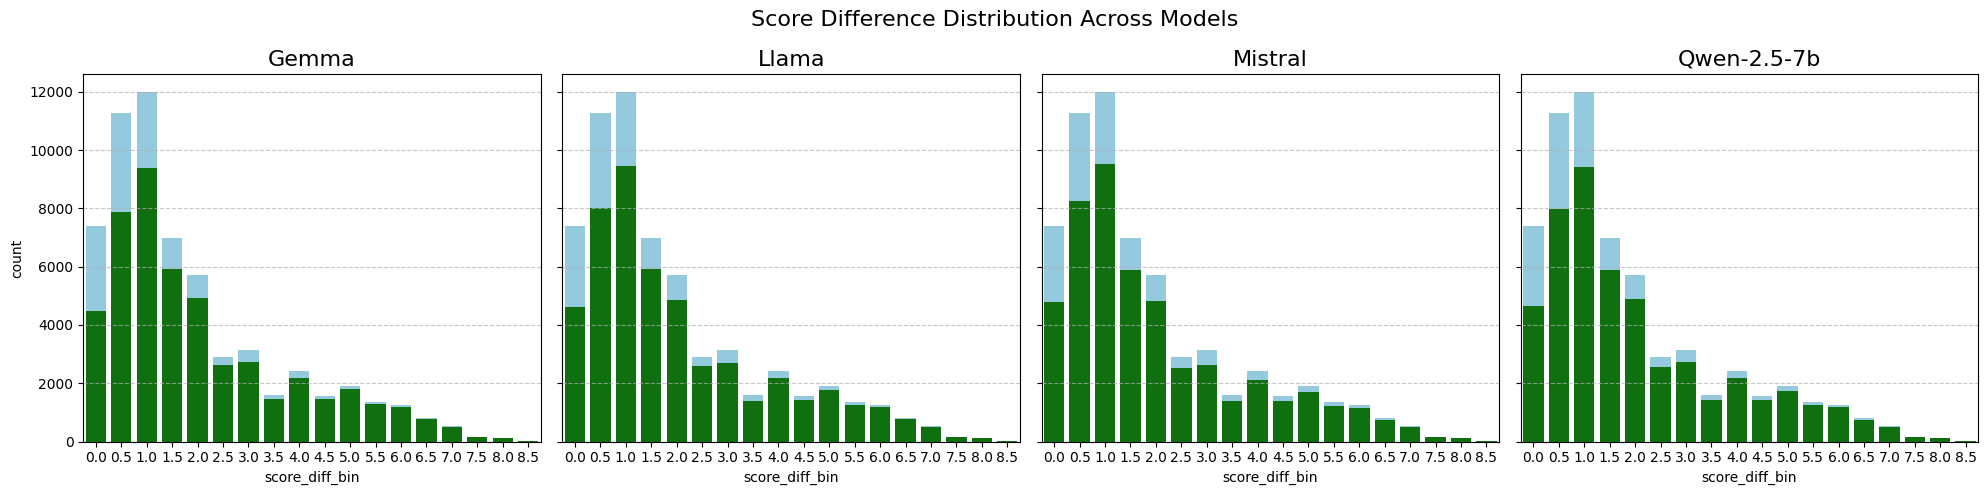

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# 定义模型名称
model_names = ['gemma', 'llama', 'mistral', 'qwen-2.5-7b']

dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']


df_count_org = pd.DataFrame([x["score_diff"] for x in dataset if x["score_diff"] is not None], columns=["score_diff"])

# **四舍五入到最近的 0.5**
df_count_org["score_diff_bin"] = df_count_org["score_diff"].apply(lambda x: round(x * 2) / 2)

# 计算不同 score_diff_bin 下的数据数量
df_count_org = df_count_org.groupby("score_diff_bin").size().reset_index(name="count")

# # **确保 score_diff_bin 是数值类型**
# df_count_org["score_diff_bin"] = df_count_org["score_diff_bin"].astype(float)

# # 获取 X 轴的最小值和最大值，并确保它们是 float 类型
# min_x = float(df_count_org["score_diff_bin"].min())
# max_x = float(df_count_org["score_diff_bin"].max())


data_perc=0.8


fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# 遍历每个模型，绘制直方图和 KDE 曲线
for i, model_name in enumerate(model_names):
    ax = axes[i]  # 选定当前子图

    sorted_dataset = dataset.sort(f"{model_name}_learning_order", reverse=False)
    subset = sorted_dataset.select(list(range(int(len(dataset)*data_perc))))

    # 计算所有数据的 score_diff，并四舍五入到最近的 0.5
    df_count = pd.DataFrame([x["score_diff"] for x in subset if x["score_diff"] is not None], columns=["score_diff"])

    # **四舍五入到最近的 0.5**
    df_count["score_diff_bin"] = df_count["score_diff"].apply(lambda x: round(x * 2) / 2)

    # 计算不同 score_diff_bin 下的数据数量
    df_count = df_count.groupby("score_diff_bin").size().reset_index(name="count")

    # **确保 score_diff_bin 是数值类型**
    df_count["score_diff_bin"] = df_count["score_diff_bin"].astype(float)

    # 获取 X 轴的最小值和最大值，并确保它们是 float 类型
    min_x = float(df_count["score_diff_bin"].min())
    max_x = float(df_count["score_diff_bin"].max())

    sns.barplot(x=df_count_org["score_diff_bin"], y=df_count_org["count"], color="skyblue", ax=ax)
    sns.barplot(x=df_count["score_diff_bin"], y=df_count["count"], color="green", ax=ax)

    # 设置 X 轴的刻度（确保按 0.5 间隔显示）
    ax.set_xticks(np.arange(min_x, 2 * max_x + 0.5, 1))

    # 添加横向网格线（仅 Y 轴）
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    ax.set_title(f"{model_name.capitalize()}", fontsize=16)


plt.suptitle("Score Difference Distribution Across Models", fontsize=16)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()



In [44]:
import json
from datasets import load_dataset

# 定义模型名称
model_names = ['gemma', 'llama', 'mistral', 'qwen-2.5-7b']

dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
dataset = dataset.remove_columns(['prompt', 'messages', 'prompt_id'])#)

for i, model_name in enumerate(model_names):
    sorted_dataset = dataset.sort(f"{model_name}_learning_order", reverse=False)
    print("#" * 80)
    print(f"*** Model Name: {model_name} ***")

    # 取出 -5000 位置的样本
    sample = sorted_dataset[-5000]

    # **格式化 JSON 并打印**
    print(json.dumps(sample, indent=4, ensure_ascii=False))  # 确保中文正常显示


################################################################################
*** Model Name: gemma ***
{
    "chosen": [
        {
            "content": "What are the top tourist attractions in and around Landers that visitors should not miss?",
            "role": "user"
        },
        {
            "content": "Here are the top tourist attractions in and around Landers that visitors should not miss:\n\n* **Joshua Tree National Park:** This park is home to a unique ecosystem of Joshua trees, yuccas, and cacti. Visitors can hike, bike, or take a ranger-led tour of the park.\n* **Keys View:** This overlook offers stunning views of the Coachella Valley, the San Andreas Fault, and the Salton Sea.\n* **Giant Rock:** This 30-ton boulder is one of the largest free-standing boulders in the world.\n* **Mesquite Flat Sand Dunes:** These sand dunes are a great place to sandboard, hike, or simply enjoy the desert landscape.\n* **Morman Rocks:** These unusual rock formations are said to re

In [22]:
dataset.sort(f"gemma_learning_order", reverse=False)
dataset[-1]

{'prompt': 'Have you ever experimented with sensory engagement in your presentations? Share a time when you used smell, taste, touch or sound to enhance your message and captivate your audience.',
 'prompt_id': '6fd66c4ffd2907d46c4950d969dc391971ec3bc2149efea4b52854d426026a1f',
 'chosen': [{'content': 'Have you ever experimented with sensory engagement in your presentations? Share a time when you used smell, taste, touch or sound to enhance your message and captivate your audience.',
   'role': 'user'},
  {'content': "As an AI language model, I do not have personal experiences or memories, so I cannot share a specific anecdote. However, I can provide you with an example of how someone might use sensory engagement to elevate their presentation and captivate their audience.\n\nLet's say a presenter is talking about the importance of environmental conservation and how it affects our daily lives at a conference. To make the presentation more engaging and memorable, they could use sensory s

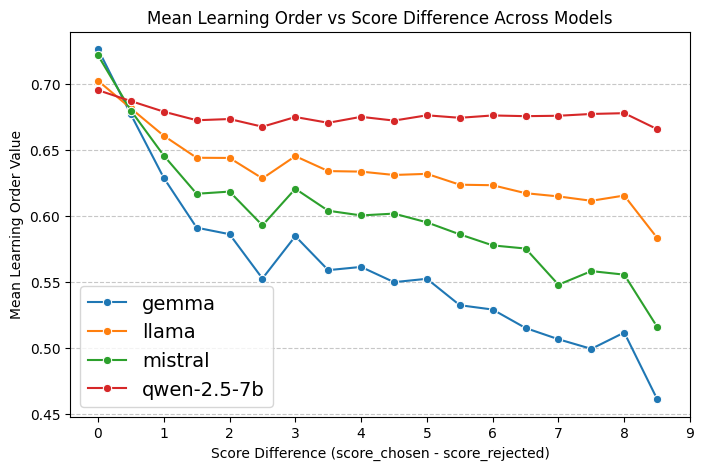

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 定义模型名称
model_names = ['gemma', 'llama', 'mistral', 'qwen-2.5-7b']

# 创建绘图
plt.figure(figsize=(8, 5))

# 记录所有 score_diff 用于确定 X 轴刻度
all_score_diffs = []

# 遍历每个模型，计算 score_diff vs mean_learning_order 并绘制曲线
for model_name in model_names:
    # 过滤 None 值的数据
    filtered_data = [(x["score_diff"], x[f"{model_name}_learning_order"]) for x in combined_dataset 
                     if x["score_diff"] is not None and x[f"{model_name}_learning_order"] is not None]

    # 转换为 Pandas DataFrame
    df = pd.DataFrame(filtered_data, columns=["score_diff", "learning_order"])

    # **四舍五入到最近的 0.5**
    df["score_diff"] = df["score_diff"].apply(lambda x: round(x * 2) / 2)

    # 计算不同 score_diff 对应的 learning_order 平均值
    df_mean = df.groupby("score_diff")["learning_order"].mean().reset_index()

    # 记录所有 score_diff 值
    all_score_diffs.extend(df_mean["score_diff"].tolist())

    # 绘制曲线
    sns.lineplot(x=df_mean["score_diff"], y=df_mean["learning_order"], marker="o", label=f"{model_name}")

# 计算 X 轴的范围并设置 0.5 间隔的刻度
min_x = np.floor(min(all_score_diffs))
max_x = np.ceil(max(all_score_diffs))
plt.xticks(np.arange(min_x, max_x + 0.5, 1))  # 以 0.5 为间隔

# 添加标题和标签
plt.xlabel("Score Difference (score_chosen - score_rejected)")
plt.ylabel("Mean Learning Order Value")
plt.title("Mean Learning Order vs Score Difference Across Models")
plt.legend(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.show()


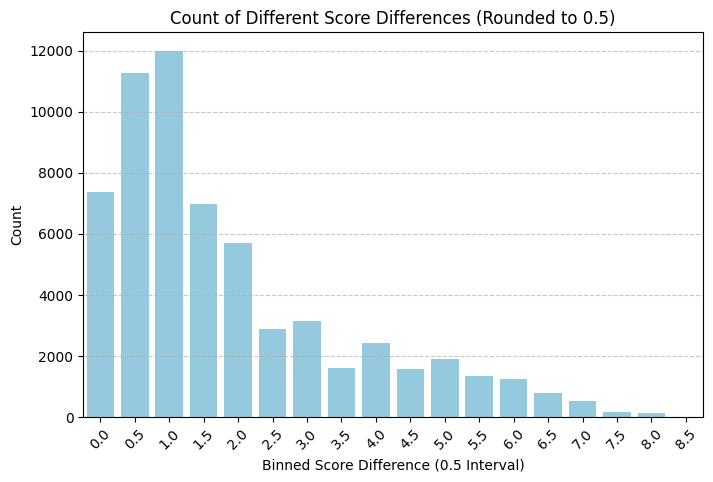

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 计算所有数据的 score_diff，并四舍五入到最近的 0.5
df_count = pd.DataFrame([x["score_diff"] for x in combined_dataset if x["score_diff"] is not None], columns=["score_diff"])

# **四舍五入到最近的 0.5**
df_count["score_diff_bin"] = df_count["score_diff"].apply(lambda x: round(x * 2) / 2)

# 计算不同 score_diff_bin 下的数据数量
df_count = df_count.groupby("score_diff_bin").size().reset_index(name="count")

# **确保 score_diff_bin 是数值类型**
df_count["score_diff_bin"] = df_count["score_diff_bin"].astype(float)

# 获取 X 轴的最小值和最大值，并确保它们是 float 类型
min_x = float(df_count["score_diff_bin"].min())
max_x = float(df_count["score_diff_bin"].max())

# 创建图表
plt.figure(figsize=(8, 5))
sns.barplot(x=df_count["score_diff_bin"], y=df_count["count"], color="skyblue")

# 设置 X 轴的刻度（确保按 0.5 间隔显示）
plt.xticks(np.arange(min_x, 2 * max_x + 0.5, 1))

# 添加横向网格线（仅 Y 轴）
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 添加标题和标签
plt.xlabel("Binned Score Difference (0.5 Interval)")
plt.ylabel("Count")
plt.title("Count of Different Score Differences (Rounded to 0.5)")

# 旋转 X 轴刻度，防止重叠
plt.xticks(rotation=45)

# 显示图表
plt.show()


### Push data to huggingface

- selective DPO
- raw score diff

In [22]:
from datasets import load_dataset, Dataset, DatasetDict


raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']

llama_sorted_dataset = raw_dataset.sort(f"llama_learning_order", reverse=False)

llama_sorted_dataset = llama_sorted_dataset.remove_columns([column_name for column_name in llama_sorted_dataset.column_names if column_name not in test_dataset.column_names ])

llama_dataset = DatasetDict({
    'train': llama_sorted_dataset,
    'test': test_dataset
})
llama_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_llama_learning_order")


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_llama_learning_order/commit/606455251ca1e4b2c993a5bb457624791fe1bd1e', commit_message='Upload dataset', commit_description='', oid='606455251ca1e4b2c993a5bb457624791fe1bd1e', pr_url=None, pr_revision=None, pr_num=None)

In [37]:
from datasets import load_dataset, Dataset, DatasetDict


raw_dataset = load_dataset("json", data_files="ultrafeedback_with_learning_order.json")['train']
test_dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")['test_prefs']

score_diff_sorted_dataset = raw_dataset.sort(f"score_diff", reverse=True)

score_diff_sorted_dataset = score_diff_sorted_dataset.remove_columns([column_name for column_name in score_diff_sorted_dataset.column_names if column_name not in test_dataset.column_names ])

score_diff_dataset = DatasetDict({
    'train': score_diff_sorted_dataset,
    'test': test_dataset
})
score_diff_dataset.push_to_hub("jlpang888/ultrafeedback_sorted_score_diff")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jlpang888/ultrafeedback_sorted_score_diff/commit/0fc95d3626e09d49842c55f12c473b39579784f6', commit_message='Upload dataset', commit_description='', oid='0fc95d3626e09d49842c55f12c473b39579784f6', pr_url=None, pr_revision=None, pr_num=None)